# EXAMEN 2

## EJERCICIO 1

Predice las ventas mensuales de una cadena de tiendas minoristas para los próximos dos meses, teniendo en cuenta los 12 últimos meses anteriores.

Pasos a seguir:

* Preparación de Datos:
    * Cargar los datos históricos de ventas (retail_sales.csv).
    * Gráfica de las ventas a lo largo del tiempo.
    * Normalizar los datos (normaliza y desnormaliza los datos manualmente)
    * Dividir los datos en conjuntos de entrenamiento, validación y pruebas.
    * Crear secuencias de datos de longitud fija para entrenar la red.

* Construcción del Modelo:   
    * Utilizar una Red Neuronal Recurrente (RNN) con celdas GRU (Gated Recurrent Unit) (mínimo 2 capas)
    * Añadir una capa densa al final para la predicción de las ventas.

* Entrenamiento:
    * Configurar el modelo con una función de pérdida MSE (Mean Squared Error), un optimizador Adam y la métrica del error absoluto medio.
    * Utiliza detección temprana

* Evaluación y Predicción:
    * Evaluar el modelo en el conjunto de prueba para verificar su rendimiento.
    * Realizar predicciones de las ventas para los próximos 2 meses (abril y mayo) 
   
    Nota: si te fijas en los datos es muy fácil predecir el resultado para abril y mayo comprueba que los resultados que obtienes concuerdan con lo esperado para estar seguro de que está bien hecho.

In [74]:
import pandas as pd

# Carga de datos
df_ventas = pd.read_csv("retail_sales.csv").set_index("Month") # Ponemos como índice el mes
df_ventas

,Sales
Month,
2014-01-01,1000
2014-02-01,2000
2014-03-01,3000
2014-04-01,4000
2014-05-01,1000
...,...
2023-11-01,3000
2023-12-01,4000
2024-01-01,1000


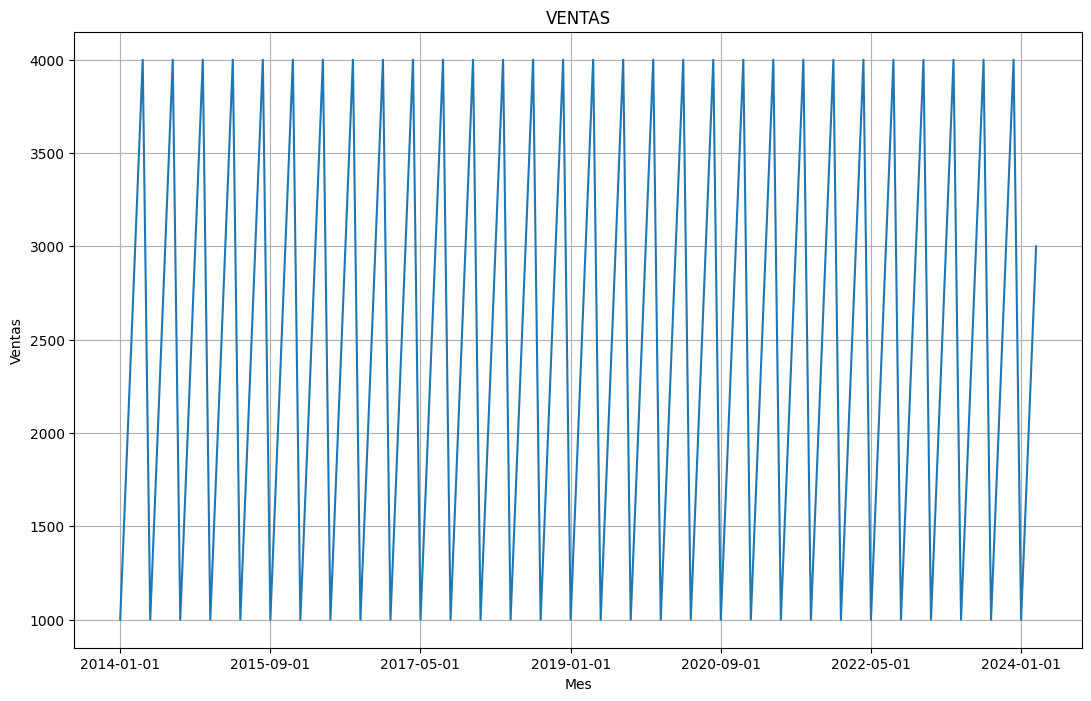

In [75]:
import matplotlib.pyplot as plt

# Gráfico
df_ventas.plot(legend=False, figsize=(13, 8), grid=True)
plt.title("VENTAS")
plt.ylabel("Ventas")
plt.xlabel("Mes")
plt.show()

In [76]:
# Normalización
media = df_ventas["Sales"].mean()
desviacion = df_ventas["Sales"].std()

df_ventas["Sales"] = (df_ventas["Sales"] - media) / desviacion

df_ventas

,Sales
Month,
2014-01-01,-1.329723
2014-02-01,-0.435975
2014-03-01,0.457774
2014-04-01,1.351522
2014-05-01,-1.329723
...,...
2023-11-01,0.457774
2023-12-01,1.351522
2024-01-01,-1.329723


In [77]:
# División de conjuntos
# Teniendo en cuenta 12 meses queremos predecir 2, por lo que al menos en cada conjunto tiene que haber 14 meses/filas
df_ventas_train = df_ventas["2014-01-01":"2020-12-01"]
df_ventas_valid = df_ventas["2021-01-01":"2022-12-01"]
df_ventas_test = df_ventas["2023-01-01":"2024-03-01"]

In [78]:
df_ventas_train

,Sales
Month,
2014-01-01,-1.329723
2014-02-01,-0.435975
2014-03-01,0.457774
2014-04-01,1.351522
2014-05-01,-1.329723
...,...
2020-08-01,1.351522
2020-09-01,-1.329723
2020-10-01,-0.435975


In [79]:
df_ventas_valid

,Sales
Month,
2021-01-01,-1.329723
2021-02-01,-0.435975
2021-03-01,0.457774
2021-04-01,1.351522
2021-05-01,-1.329723
2021-06-01,-0.435975
2021-07-01,0.457774
2021-08-01,1.351522
2021-09-01,-1.329723


In [80]:
df_ventas_test

,Sales
Month,
2023-01-01,-1.329723
2023-02-01,-0.435975
2023-03-01,0.457774
2023-04-01,1.351522
2023-05-01,-1.329723
2023-06-01,-0.435975
2023-07-01,0.457774
2023-08-01,1.351522
2023-09-01,-1.329723


In [81]:
import tensorflow as tf

# Creación de secuencias de longitud fija

# Función que separa una secuencia (input) y su objetivo (target)
# Queremos predecir los dos meses siguientes, por lo que ahead=2
# La columna objetivo es la primera (la única), por lo que su indice target_col=0
def split_inputs_and_targets(mulvar_series, ahead=2, target_col=0):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

seq_train = tf.keras.utils.timeseries_dataset_from_array(
    df_ventas_train.to_numpy(dtype="float32"), # Origen
    targets=None, # Sin objetivo, se sacará con la función split_inputs_and_targets
    sequence_length=12 + 2, # Secuencia de 12 meses (input) + 2 meses de objetivo
    batch_size=2, # Tamaño de batch
    shuffle=True, # Como es entrenamiento, los mezclamos
    seed=42
).map(split_inputs_and_targets) # Aplicamos la función para que nos separe la secuencia y objetivo

# Lo mismo para los conjuntos de prueba y validación, sin mezclar.
seq_valid = tf.keras.utils.timeseries_dataset_from_array(
    df_ventas_valid.to_numpy(dtype="float32"),
    targets=None,
    sequence_length=12 + 2,
    batch_size=2
).map(split_inputs_and_targets)

seq_test = tf.keras.utils.timeseries_dataset_from_array(
    df_ventas_test.to_numpy(dtype="float32"),
    targets=None,
    sequence_length=12 + 2,
    batch_size=2
).map(split_inputs_and_targets)

In [82]:
list(seq_train)

[(<tf.Tensor: shape=(2, 12, 1), dtype=float32, numpy=
  array([[[-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
          [ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
          [ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
          [ 1.3515221 ]],
  
         [[ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
          [ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
          [ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ]]], dtype=float32)>,
  <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
  array([[-1.3297234 , -0.43597487],
         [ 1.3515221 , -1.3297234 ]], dtype=float32)>),
 (<tf.Tensor: shape=(2, 12, 1), dtype=float32, numpy=
  array([[[ 0.4577736 ],
          [ 1.3515221 ],
          [-1.3297234 ],
          [-0.43597487],
          [ 0.4577736 ],
 

>Como ejemplo cogemos el primer batch. 2 secuencias conforman el batch. 12 elementos por secuencia, los 12 meses previos con los que queremos predecir. Una característica por secuencia, las ventas. El siguiente elemento es el tensor objetivo. 2 secuencias, una para cada input. Dos elementos por secuencia, los dos meses que intentamos predecir.

In [84]:
# Definición del modelo
modelo1 = tf.keras.Sequential([
    # Capa GRU de entrada. Recibe como input secuencias de 12 elementos (meses) con una característica cada una (ventas) -> [12, 1]
    # Como la siguiente capa también es también otra GRU que espera como entrada las secuencias, ponemos return_sequences a True
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[12, 1]),
    # Podríamos omitir el parámetro return_sequences, su valor por defecto es False.
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(2) # El resultado es un vector de 2 elementos, los 2 meses que queremos predecir a partir de cada secuencia.
])

In [85]:
# Compilación
modelo1.compile(
    optimizer="adam", # Optimizador Adam
    loss="mean_squared_error", # Pérdida error cuadrado medio
    metrics=["mean_absolute_error"] # Métrica error absoluto medio
)

In [86]:
# Detección temprana
# Monitoriza la función de pérdida en el conjunto de validación.
# Cuando no mejore significativamente a las 50 épocas para.
deteccion_temprana = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

In [87]:
# Entrenamiento
history = modelo1.fit(
    seq_train,
    epochs=500,
    validation_data=seq_valid,
    callbacks=[deteccion_temprana],
    batch_size=2
)

Epoch 1/500


36/36 [==============================] - 5s 27ms/step - loss: 0.8710 - mean_absolute_error: 0.8180 - val_loss: 0.6732 - val_mean_absolute_error: 0.6951
Epoch 2/500
36/36 [==============================] - 0s 9ms/step - loss: 0.6216 - mean_absolute_error: 0.6366 - val_loss: 0.4028 - val_mean_absolute_error: 0.4733
Epoch 3/500
36/36 [==============================] - 0s 7ms/step - loss: 0.3545 - mean_absolute_error: 0.4681 - val_loss: 0.2206 - val_mean_absolute_error: 0.3858
Epoch 4/500
36/36 [==============================] - 0s 8ms/step - loss: 0.1694 - mean_absolute_error: 0.3597 - val_loss: 0.1072 - val_mean_absolute_error: 0.3001
Epoch 5/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0754 - mean_absolute_error: 0.2441 - val_loss: 0.0367 - val_mean_absolute_error: 0.1820
Epoch 6/500
36/36 [==============================] - 0s 7ms/step - loss: 0.0264 - mean_absolute_error: 0.1392 - val_loss: 0.0155 - val_mean_absolute_error: 0.1000
Epoch 7/500
36/36 [==============

In [89]:
# Evaluación en el conjunto de prueba
loss, metric = modelo1.evaluate(seq_test)

1/1 [==============================] - 0s 38ms/step - loss: 6.6613e-16 - mean_absolute_error: 2.2352e-08


>Función de pérdida y error absoluto medio muy bajos. Buen rendimiento en el conjunto de pruebas.

In [103]:
# Predicción
# Para predecir los meses de abril y mayo, tendremos que pasarle una secuencia de los 12 meses anteriores a abril.
# Cogemos del DF de test los 12 últimos meses y creamos una secuencia a partir de ese DF
df_a_predecir = df_ventas_test[-12:]
seq_a_predecir = tf.keras.utils.timeseries_dataset_from_array(
    df_a_predecir.to_numpy(dtype="float32"),
    targets=None,
    sequence_length=12
)

# Le pasamos al modelo la secuencia para que haga la predicción
prediccion = modelo1.predict(seq_a_predecir)

# Desnormalizamos
print(f"Predicción para abril y mayo: {(prediccion * desviacion) + media}")

1/1 [==============================] - 0s 49ms/step


Predicción para abril y mayo: [[4000.      999.9999]]


>Si nos fijamos en los datos y en la gráfica, las ventas siguen siempre la secuencia 1000, 2000, 3000, 4000 y vuelta a 1000. Las ventas de marzo eran 3000 por lo que la predicción de abril 4000 y mayo 1000 es correcta.

## EJERCICIO 2

Para este ejercicio, entrenaremos un modelo de Hugging Face ya preentrenado para una tarea de clasificación de sentimientos en español. Utilizaremos un modelo BERT en español como base. 

Los datos de entrenamiento, validación, pruebas y los nuevos datos para hacer predicciones son los siguientes:

``````
# Datos de entrenamiento
datos_entrenamiento = [
    ("Me encanta esta película, es fantástica.", "positivo"),
    ("Esta es la mejor película del año.", "positivo"),
    ("Qué aburrida fue esta película.", "negativo"),
    ("Esta película no es lo que esperaba, pero de buena manera.", "positivo"),
    ("No creo que quiera ver esa película de nuevo.", "negativo"),
    ("No me gustó la película, fue terrible.", "negativo"),
    ("Me sentí decepcionado por la película.", "negativo"),
    ("Increíble, me encantó cada parte de la película.", "positivo"),
]

# Datos de validación
datos_validacion = [
    ("No me gustó mucho esta película.", "negativo"),
    ("La película estuvo genial, muy recomendada.", "positivo"),
]

# Datos de prueba
datos_prueba = [
    ("La película no fue lo que esperaba.", "negativo"),
    ("Me sorprendió gratamente esta película.", "positivo"),
]

# Nuevos datos para predicciones
nuevos_datos = [
    "Esta película es lo que esperaba.",
    "Quiero ver esa película de nuevo.",
]
``````

Los pasos a seguir son los siguientes:
* Carga el modelo BERT preentrenado y su tokenizador.
* Prepara los conjuntos de datos, validación y pruebas (tokenizar y crear el dataset de TensorFlow)
* Entrena el modelo con nuestros datos de entrenamiento.
* Evalúa el rendimiento del modelo con el conjunto de datos de prueba.
* Haz predicciones para los datos nuevos

Evidentemente los resultados van a ser muy malos porque no hay datos suficientes

In [24]:
# Datos de entrenamiento
datos_entrenamiento = [
    ("Me encanta esta película, es fantástica.", "positivo"),
    ("Esta es la mejor película del año.", "positivo"),
    ("Qué aburrida fue esta película.", "negativo"),
    ("Esta película no es lo que esperaba, pero de buena manera.", "positivo"),
    ("No creo que quiera ver esa película de nuevo.", "negativo"),
    ("No me gustó la película, fue terrible.", "negativo"),
    ("Me sentí decepcionado por la película.", "negativo"),
    ("Increíble, me encantó cada parte de la película.", "positivo"),
]

# Datos de validación
datos_validacion = [
    ("No me gustó mucho esta película.", "negativo"),
    ("La película estuvo genial, muy recomendada.", "positivo"),
]

# Datos de prueba
datos_prueba = [
    ("La película no fue lo que esperaba.", "negativo"),
    ("Me sorprendió gratamente esta película.", "positivo"),
]

# Nuevos datos para predicciones
nuevos_datos = [
    "Esta película es lo que esperaba.",
    "Quiero ver esa película de nuevo.",
]

In [25]:
# Modelo BERT y tokenizador
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("edumunozsala/bertin_base_sentiment_analysis_es")
model = TFAutoModelForSequenceClassification.from_pretrained("edumunozsala/bertin_base_sentiment_analysis_es")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [26]:
# Preprocesamiento de datos.
def preprocesamiento(datos):
    """Función de preprocesado
    
    Coge las listas proporcionadas y separa en X e y para pasarlas por el modelo después.

    Args:
        datos (list[tuple[str, str]]): Lista de datos. Cada elemento de la lista es una tupla (texto, etiqueta)

    Returns:
        tuple[list[str], list[int]]: Devuelve una tupla del tipo (X, y), donde X es una lista de strings e y una lista de enteros
        codificados como 0 negativo y 1 positivo
    """
    X = []
    y = []
    for (texto, etiqueta) in datos:
        X.append(texto)
        if etiqueta == "positivo":
            y.append(1)
        else:
            y.append(0)
    return X, y

In [27]:
# Aplicamos la función de preprocesado a los 3 conjuntos de datos
X_train, y_train = preprocesamiento(datos_entrenamiento)
X_valid, y_valid = preprocesamiento(datos_validacion)
X_test, y_test = preprocesamiento(datos_prueba)

In [28]:
# Pasamos los conjuntos de entrenamiento y validacion por el tokenizador
encoded_train = tokenizer(X_train, truncation=True, padding=True, max_length=128)
encoded_valid = tokenizer(X_valid, truncation=True, padding=True, max_length=128)
encoded_test = tokenizer(X_test, truncation=True, padding=True, max_length=128)

In [29]:
# Creamos los datasets de TF
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encoded_train),
    y_train
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encoded_valid),
    y_valid
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encoded_test),
    y_test
))

In [30]:
# Compilación del modelo
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [31]:
# Entrenamiento
model.fit(
    train_dataset.batch(8),
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)],
    validation_data=valid_dataset.batch(8)
)

Epoch 1/200


1/1 [==============================] - 42s 42s/step - loss: 5.8156 - accuracy: 0.8750 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 7.6685 - accuracy: 0.5000 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 8/200
1/1 [===========================

In [33]:
# Evaluación en el conjunto de prueba
model.evaluate(test_dataset.batch(8))

1/1 [==============================] - 0s 84ms/step - loss: 7.6685 - accuracy: 0.5000


[7.668546676635742, 0.5]

>Un 50% de exactitud en el conjunto de prueba

In [46]:
# Predicciones de los datos nuevos
encoded_new = tokenizer(nuevos_datos, truncation=True, padding=True, max_length=128, return_tensors="tf") # Tokenizar los inputs
prediccion = model(encoded_new) # Genera predicciones
tf.argmax(prediccion.logits) # Transformamos las predicciones a logits y con argmax obtenemos la probabilidad más alta

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1], dtype=int64)>

>El resultado es [1, 1], por lo que ha entendido ambas frases como positivas.

## EJERCICIO 3

El conjunto de datos cats_vs_dogs https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419 es conjunto de imágenes de perros y gatos.

Tienes que entrenar un modelo de redes convolucional para que aprenda a clasificar entre perro y gato, pero no vamos a empezar de cero, vamos a usar alguna de las redes ya existentes: InceptionV3

Tienes que seguir los siguientes pasos
* Carga el conjunto de imágenes (entrenamiento, validación (coge los datos del conjunto de pruebas) y pruebas)
* Explora los datos: dimensiones, número de elementos, dibuja algunas imágenes con sus etiquetas...
* Prepara los datos: añad3 más elementos al conjunto de entrenamiento (rotando, trasladando... las imágenes actuales) y prepara los datos para el modelo
* Entrena un modelo para estos datos(usando: InceptionV3)
* Busa una imagen en Internet y haz una predicción

Puede usar take(10) a la hora de entrenar aunque los resultados sean malísimos, con el fin de que no pierdas tiempo. Usa pocos epoch y añade como comentarios que valores pondrías realmente.

>Lo he hecho en un notebook en Collab, me daba el mismo problema que a Badr.

## EJERCICIO 4

Este ejercicio lo podéis hacer en Google Colab, tenéis que detectar cuantos coches cruzan la línea. Tenéis el video origen (trafico.mp4) así como el video de como quiero que quede (trafico_result.mp4)